### Pymongo
- /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
- pip install pymongo

In [82]:
import pymongo

client = pymongo.MongoClient(host= '10.241.49.55', port=20011, username='dba',password='dba')
# print(client.list_database_names())
db= client['lai-alpha']

In [83]:
import pandas as pd

# 방법1 cursor - dict list - dataframe
paDict = db.productApplication.find_one({"name":"default"})
default_pa_id = paDict['_id']

total_resource_count = db.resource.count_documents({
    "type":{
         "$in":['server','legacy-server','legacy-physical-server']
    }
})
total_server_count = db.server.count_documents({})

In [84]:
print(total_resource_count)

127873


In [85]:
pipeline =[
    {
        '$lookup': {
            'from': 'application', 
            'localField': 'parentGroups._id', 
            'foreignField': '_id', 
            'as': 'app'
        }
    }, {
        '$match': {
            'type': {
                '$in': [
                    'server', 'legacy-server', 'legacy-physical-server'
                ]
            }, 
            'app': {
                '$ne': []
            }, 
            'app.parentGroup._id': {
                '$ne': default_pa_id
            }
        }
    }, {
        '$count': 'count'
    }
]

lookupResult = db.resource.aggregate(pipeline)
registered_server_count =list(lookupResult)[0]['count']

In [86]:
print(registered_server_count)

61761


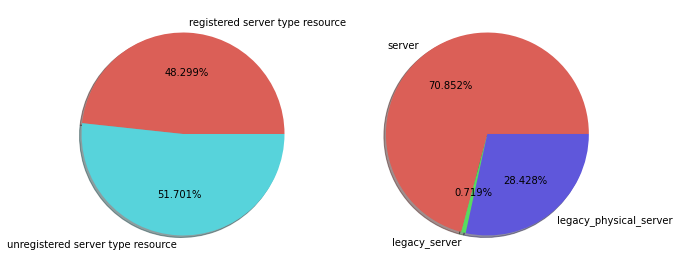

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
unregistered_server_count=total_resource_count-registered_server_count
values1 = [registered_server_count, unregistered_server_count]
labels1 = ["registered server type resource", "unregistered server type resource"]
colors1 = sns.color_palette('hls',len(labels1))

plt.subplot(1,2,1)
result1 = plt.pie(values1,labels=labels1, autopct='%.3f%%', colors = colors1, shadow=True)

server_count = db.resource.count_documents({"type":"server"})
legacy_server_count= db.resource.count_documents({"type":"legacy-server"})
legacy_physical_server_count=db.resource.count_documents({"type":"legacy-physical-server"})

values2 = [server_count,legacy_server_count,legacy_physical_server_count ]
labels2 = ["server", "legacy_server", "legacy_physical_server"]
colors2 = sns.color_palette('hls',len(labels2))

plt.subplot(1,2,2)
result2 = plt.pie(values2,labels=labels2, autopct='%.3f%%', colors = colors2, shadow=True)

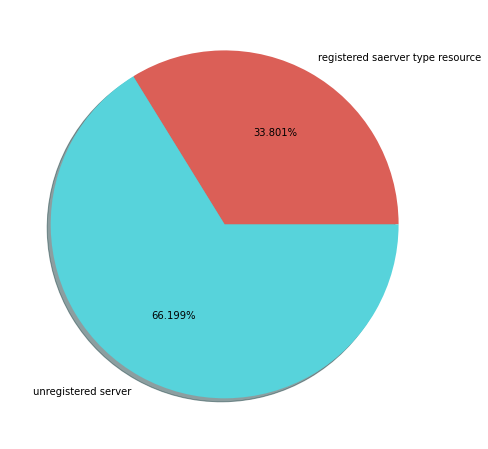

In [89]:
plt.figure(figsize=(10,8))

values3 = [registered_server_count, total_server_count-registered_server_count]
labels3 = ["registered saerver type resource", "unregistered server"]
colors3 = sns.color_palette('hls',len(labels3))
result3 = plt.pie(values3,labels=labels3, autopct='%.3f%%', colors = colors3, shadow=True)

In [56]:
from datetime import datetime

def save_portion_and_count_frame(result, labels, values, path, prefix):
    percentages=[]
    for res in result[2]:
        percentages.append(res.get_text())
    portion_df = pd.DataFrame({'Target':labels, 'Portion': percentages,'Count': values})
    portion_df.to_csv(path+prefix+"_"+str(datetime.now())+".csv")
    

path="./"
save_portion_and_count_frame(result1, labels1, values1, path, "[mongodb]registered server type resources on lai resource")
save_portion_and_count_frame(result2, labels2, values2, path, "[mongodb]registered resources per type")
save_portion_and_count_frame(result3, labels3, values3, path, "[mongodb]registered server type resources on servers")

In [90]:
! rm *.csv
! ls

pymongo_registration_rate.ipynb         resource_server_registration_rate.ipynb


In [58]:
test_df =pd.read_csv("[mongodb]registered resources per type_2022-08-08 22:37:00.542193.csv")
test_df=test_df[test_df.columns[1:]]
test_df.head()

,Target,Portion,Count
0,server,84.430%,52145
1,legacy_server,1.490%,920
2,legacy_physical_server,14.080%,8696


In [91]:
!git rm --cached -r *.csv 

zsh:1: no matches found: *.csv
